<a href="https://colab.research.google.com/github/CAP4770-group9-project/final-project/blob/notebook%2Fkmeans/k-means-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering for Stock Portfolio Diversification

Diversification is a very important step in stock portfolio creation. Picking several stocks rather than just one helps to reduce some of the inherent risk with investing. However, to reap the full benefits of diversification one not only has to pick more than one stock but also ensure that the behaviour of the stocks are not correlated.

This measure of "differentiality" in stock return and variance behavior can be calculated using K means clustering. The stock price data over diffrent periods of time can be put into the clustering algorithm with the goal of clustering the stock based on diffrent behavior. Stocks from these clusters then can be chosen in order to create a well-diversified portfolio.

## Data preprocessing

### Import data and calculate parameters

Now we can import the S&P500 data into Colab

In [554]:
#change directory to where the data is located 
!pwd
%cd drive/My Drive/cap4770-project

/content/drive/My Drive/cap4770-project
[Errno 2] No such file or directory: 'drive/My Drive/cap4770-project'
/content/drive/My Drive/cap4770-project


In [555]:
import pandas as pd
import time

#use timer to get process times
start_time = time.time()

#read csv
data = pd.read_csv("SP_DAILY_2000-2020.csv")
print("read data --- %s seconds ---" % (time.time() - start_time))

availableStocks = data['Symbol'].unique()
print("Number of stocks in the dataset: ", len(availableStocks))
print(data)

read data --- 1.7465004920959473 seconds ---
Number of stocks in the dataset:  503
        Symbol        Date    Open   Close     High     Low    Volume
0          MMM  2020-03-26  131.79  135.98  136.355  130.61   5476351
1          MMM  2020-03-25  133.15  131.54  134.690  126.80   7732467
2          MMM  2020-03-24  122.29  132.72  133.450  121.00   9304832
3          MMM  2020-03-23  128.16  117.87  128.400  114.04   7920348
4          MMM  2020-03-20  138.07  124.89  139.240  122.71   9582251
...        ...         ...     ...     ...      ...     ...       ...
2250258    ZTS  2013-02-07   31.00   32.00   32.730   31.00   3800800
2250259    ZTS  2013-02-06   30.98   31.03   31.430   30.75   2126100
2250260    ZTS  2013-02-05   31.25   31.04   31.980   30.85   5013200
2250261    ZTS  2013-02-04   31.09   31.02   31.990   30.76   7695400
2250262    ZTS  2013-02-01   31.50   31.01   31.740   30.47  66789100

[2250263 rows x 7 columns]


Now we can extract the training data from the dataset

In [556]:
#create DateTime column
stocksData = data

stocksData['DateTime'] = pd.to_datetime(stocksData.apply(lambda row: row['Date'], axis=1))

print(stocksData)

        Symbol        Date    Open  ...     Low    Volume   DateTime
0          MMM  2020-03-26  131.79  ...  130.61   5476351 2020-03-26
1          MMM  2020-03-25  133.15  ...  126.80   7732467 2020-03-25
2          MMM  2020-03-24  122.29  ...  121.00   9304832 2020-03-24
3          MMM  2020-03-23  128.16  ...  114.04   7920348 2020-03-23
4          MMM  2020-03-20  138.07  ...  122.71   9582251 2020-03-20
...        ...         ...     ...  ...     ...       ...        ...
2250258    ZTS  2013-02-07   31.00  ...   31.00   3800800 2013-02-07
2250259    ZTS  2013-02-06   30.98  ...   30.75   2126100 2013-02-06
2250260    ZTS  2013-02-05   31.25  ...   30.85   5013200 2013-02-05
2250261    ZTS  2013-02-04   31.09  ...   30.76   7695400 2013-02-04
2250262    ZTS  2013-02-01   31.50  ...   30.47  66789100 2013-02-01

[2250263 rows x 8 columns]


#### Plotting Timeframe

In [557]:
#get full training data set
trainData = stocksData[(stocksData['DateTime'] > '2010-03-26') & (stocksData['DateTime'] < '2015-03-26')]

#get training data set for 2015
trainData2015 = stocksData[(stocksData['DateTime'] > '2014-03-26') & (stocksData['DateTime'] < '2015-03-26')]
print(trainData2015)

        Symbol        Date    Open   Close     High     Low   Volume   DateTime
1260       MMM  2015-03-25  166.24  162.70  166.520  162.66  2540422 2015-03-25
1261       MMM  2015-03-24  165.58  166.32  167.650  165.53  2090967 2015-03-24
1262       MMM  2015-03-23  166.83  166.13  166.905  165.83  2155702 2015-03-23
1263       MMM  2015-03-20  166.09  166.49  167.134  165.39  4371778 2015-03-20
1264       MMM  2015-03-19  166.16  165.66  166.210  164.85  1953456 2015-03-19
...        ...         ...     ...     ...      ...     ...      ...        ...
2249969    ZTS  2014-04-02   29.28   29.62   29.700   29.14  2341200 2014-04-02
2249970    ZTS  2014-04-01   28.97   29.35   29.390   28.97  3658000 2014-04-01
2249971    ZTS  2014-03-31   29.07   28.94   29.140   28.66  8689200 2014-03-31
2249972    ZTS  2014-03-28   29.46   29.01   29.510   28.91  6398900 2014-03-28
2249973    ZTS  2014-03-27   29.21   29.30   29.395   29.08  2984200 2014-03-27

[120564 rows x 8 columns]


We can perform an initial visualization of the data by plotting

In [0]:
%matplotlib notebook
%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt


In [0]:
grouped_day_stocks = []
grouped_day = []

#plot all data
#plt.figure()
#for i in range(0, len(availableStocks)):
#  grouped_day_stocks.append(stocksData[stocksData['Symbol'] == availableStocks[i]])
#  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

In [0]:
#group day for all training data
grouped_day_stocks = []
grouped_day = []

for i in range(0, len(availableStocks)):
  grouped_day_stocks.append(trainData[trainData['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))

#print("grouped day stocks")
#print(grouped_day_stocks, "\n")



In [0]:
#print(grouped_day_stocks)

In [0]:
#plot only training data
#plt.figure()
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

For this 1 year sample of the training data, we can calculate the annualized average returns (based on price at close), annualized average volatility (based on price at close), the average intraday price variation (pct change between daily high and low), average diffrence in price between open and close and annualized trading volume from the data. 

The intraday price variation and diffrence between open and close will be used as additional measures of volatility and hopefully will add richness to the resutls of the k-means analysis

In [0]:
#group day for 2015 data
grouped_day_stocks = []
grouped_day = []

for i in range(0, len(availableStocks)):
  grouped_day_stocks.append(trainData2015[trainData2015['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))

  

In [564]:
print(len(grouped_day_stocks))

503


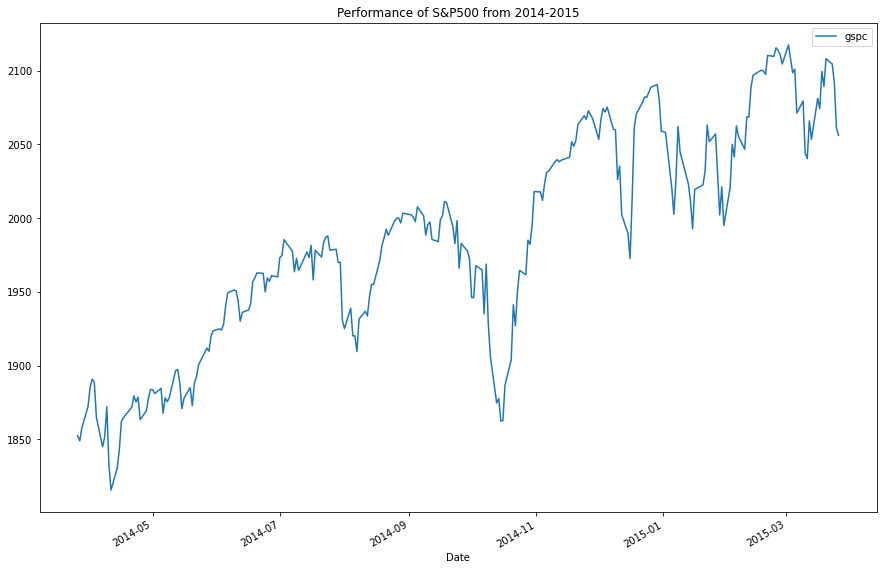

In [565]:
#plot performance of the SP500 over training period

!pip install ffn
import ffn
prices = ffn.get('^GSPC',start='2014-03-26', end='2015-03-26')
ax1 = prices.plot(title="Performance of S&P500 from 2014-2015", figsize=(15, 10))

                gspc
Date                
2014-03-27 -0.001900
2014-03-28  0.004640
2014-03-31  0.007924
2014-04-01  0.007039
2014-04-02  0.002853
...              ...
2015-03-20  0.009013
2015-03-23 -0.001746
2015-03-24 -0.006139
2015-03-25 -0.014559
2015-03-26 -0.002377

[252 rows x 1 columns]
gspc    0.111328
dtype: float64


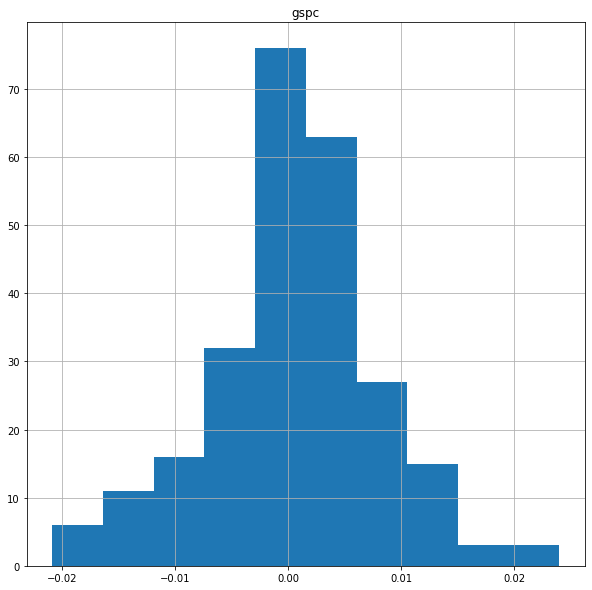

In [566]:
#plot index overall returns
returns = prices.to_returns().dropna()
print(returns)
print(returns.mean() *252)
ax = returns.hist(figsize=(10,10))

In [567]:
"""
Need to rebase price data in order to get a clearer visualization

"""

#plot only training data 2015
#plt.figure()
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

'\nNeed to rebase price data in order to get a clearer visualization\n\n'

In [568]:
annualized_data = pd.DataFrame(index=availableStocks, columns=['Returns', 'Volatility','Volume', 'HighLowDiff', 'OpenCloseDiff'])

"""
Returns seem to be off a bit, as the sp500 itself has positive average returns but the returns data is negative

"""
#aggregate annualized stock data used in cluserting analysis into dataframe
for i in range(0, len(grouped_day_stocks)):
  
  annualized_data.loc[availableStocks[i]]['Returns'] = grouped_day_stocks[i]['Close'].pct_change().mean() * 252
  annualized_data.loc[availableStocks[i]]['Volatility'] = grouped_day_stocks[i]['Close'].pct_change().std() * 252
  annualized_data.loc[availableStocks[i]]['Volume'] = grouped_day_stocks[i]['Volume'].mean() * 252
  annualized_data.loc[availableStocks[i]]['HighLowDiff'] = ((grouped_day_stocks[i]['High'] - grouped_day_stocks[i]['Low']) / grouped_day_stocks[i]['Low']).mean()
  annualized_data.loc[availableStocks[i]]['OpenCloseDiff'] = ((grouped_day_stocks[i]['Close'] - grouped_day_stocks[i]['Open']) / grouped_day_stocks[i]['Open']).mean()  

print("Annualized data for each stock in S&P500 calculated form 2014 to 2015:")
print(annualized_data)

print("Min/Max statistics: \n")
print("Max returns: ")
print(annualized_data[annualized_data['Returns'] == max(annualized_data['Returns'])], "\n")
print("Min returns: ")
print(annualized_data[annualized_data['Returns'] == min(annualized_data['Returns'])], "\n")

print("Max volatility: ")
print(annualized_data[annualized_data['Volatility'] == max(annualized_data['Volatility'],key=abs)], "\n")
print("Min volatility: ")
print(annualized_data[annualized_data['Volatility'] == min(annualized_data['Volatility'],key=abs)], "\n")

print("Max volume: ")
print(annualized_data[annualized_data['Volume'] == max(annualized_data['Volume'],key=abs)], "\n")
print("Min volume: ")
print(annualized_data[annualized_data['Volume'] == min(annualized_data['Volume'],key=abs)], "\n")

print("Max HighLowDiff: ")
print(annualized_data[annualized_data['HighLowDiff'] == max(annualized_data['HighLowDiff'],key=abs)], "\n")
print("Min HighLowDiff: ")
print(annualized_data[annualized_data['HighLowDiff'] == min(annualized_data['HighLowDiff'],key=abs)], "\n")

print("Max OpenCloseDiff: ")
print(annualized_data[annualized_data['OpenCloseDiff'] == max(annualized_data['OpenCloseDiff'],key=abs)], "\n")
print("Min OpenCloseDiff: ")
print(annualized_data[annualized_data['OpenCloseDiff'] == min(annualized_data['OpenCloseDiff'],key=abs)], "\n")

#

Annualized data for each stock in S&P500 calculated form 2014 to 2015:
        Returns Volatility       Volume HighLowDiff OpenCloseDiff
MMM   -0.192913    2.39916  5.90628e+08   0.0120139   0.000711119
ABT   -0.179184    2.56219  1.33327e+09   0.0146175   0.000502251
ABBV -0.0819894    4.43024  2.60313e+09   0.0221427   0.000568866
ABMD  -0.913676    6.76712  9.48344e+07   0.0307168    0.00185815
ACN  -0.0988941    2.73051  6.90803e+08   0.0140433   0.000706258
...         ...        ...          ...         ...           ...
YUM  -0.0580078    3.26328  7.98818e+08   0.0157174   0.000238743
ZBRA  -0.213887    4.39027  1.31668e+08   0.0230687    0.00090546
ZBH   -0.195326    3.44852  3.14272e+08   0.0162313  -6.55949e-05
ZION   0.143904    3.47235   6.4069e+08   0.0205199  -0.000154421
ZTS   -0.439027    3.25018  9.31993e+08   0.0175066    0.00123164

[503 rows x 5 columns]
Min/Max statistics: 

Max returns: 
      Returns Volatility       Volume HighLowDiff OpenCloseDiff
AAPL  5.50024

###Plotting

####4D Plot | Returns, Volatility, Volume, OpenCloseDiff

We will now attempt to plot the returns, volatility, volume and openclose diff attributes

In [569]:
#Concatenating the returns and variances and volume into a single data-frame
ret_var_vol_ocDiff = annualized_data.drop(['HighLowDiff'], axis=1)
print(ret_var_vol_ocDiff)

        Returns Volatility       Volume OpenCloseDiff
MMM   -0.192913    2.39916  5.90628e+08   0.000711119
ABT   -0.179184    2.56219  1.33327e+09   0.000502251
ABBV -0.0819894    4.43024  2.60313e+09   0.000568866
ABMD  -0.913676    6.76712  9.48344e+07    0.00185815
ACN  -0.0988941    2.73051  6.90803e+08   0.000706258
...         ...        ...          ...           ...
YUM  -0.0580078    3.26328  7.98818e+08   0.000238743
ZBRA  -0.213887    4.39027  1.31668e+08    0.00090546
ZBH   -0.195326    3.44852  3.14272e+08  -6.55949e-05
ZION   0.143904    3.47235   6.4069e+08  -0.000154421
ZTS   -0.439027    3.25018  9.31993e+08    0.00123164

[503 rows x 4 columns]


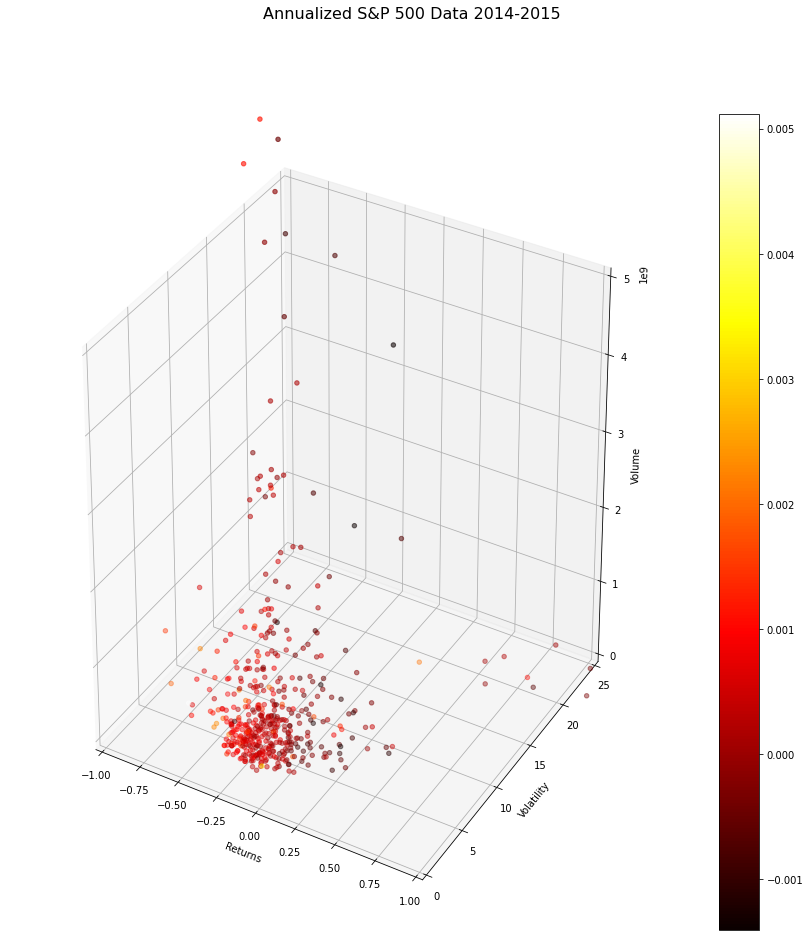

In [570]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#the below graph plots returns, volatility and volume on the axes and uses a heat map to display OpenCloseDiff
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('Annualized S&P 500 Data 2014-2015', fontsize=16)

x = list(ret_var_vol_ocDiff['Returns'].dropna().values)
y = list(ret_var_vol_ocDiff['Volatility'].dropna().values)
z = list(ret_var_vol_ocDiff['Volume'].dropna().values)
c = list(ret_var_vol_ocDiff['OpenCloseDiff'].dropna().values)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')
ax.set_xlim(-1,1)
ax.set_zlim(0,.5e10)
ax.set_ylim(0,25)

plt.show()

For now we will run the K means using only 3 attributes, the mean returns, variance, and volume

In [571]:
#Concatenating the returns and variances and volume into a single data-frame
ret_var_vol = annualized_data.drop(['HighLowDiff','OpenCloseDiff'], axis=1)
print(ret_var_vol)

        Returns Volatility       Volume
MMM   -0.192913    2.39916  5.90628e+08
ABT   -0.179184    2.56219  1.33327e+09
ABBV -0.0819894    4.43024  2.60313e+09
ABMD  -0.913676    6.76712  9.48344e+07
ACN  -0.0988941    2.73051  6.90803e+08
...         ...        ...          ...
YUM  -0.0580078    3.26328  7.98818e+08
ZBRA  -0.213887    4.39027  1.31668e+08
ZBH   -0.195326    3.44852  3.14272e+08
ZION   0.143904    3.47235   6.4069e+08
ZTS   -0.439027    3.25018  9.31993e+08

[503 rows x 3 columns]


####3D Plot | Returns, Volatility, Volume

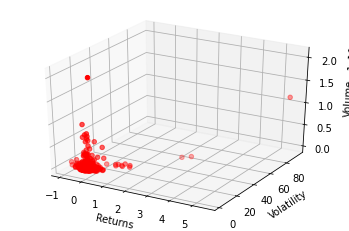

In [572]:
%matplotlib inline
#first plot data to spot outliers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)
z = list(ret_var_vol['Volume'].dropna().values)
#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()

In [0]:
#identify the volatility outlier, drop, then graph again
#2014-2015 volatility outliers 'AAPL', 'V', 'HBI'
#outlier = ret_var_vol['Volatility'] == max(ret_var_vol['Volatility'],key=abs)
#outlierIndex = ret_var_vol[outlier].index
#print(outlierIndex, "\n")

"""
Maybe can use z-score to remove outliers

"""

outlierIndex = ['AAPL','V','HBI']
ret_var_vol.drop(outlierIndex, inplace =True)

In [0]:
#code to drop volume outliers
#2014 to 2015 volume outlier 'BAC'
#outlier = ret_var_vol['Volume'] == max(ret_var_vol['Volume'],key=abs)
#outlierIndex = ret_var_vol[outlier].index
#print(outlierIndex, "\n")

outlierIndex = 'BAC'
ret_var_vol.drop(outlierIndex, inplace =True)

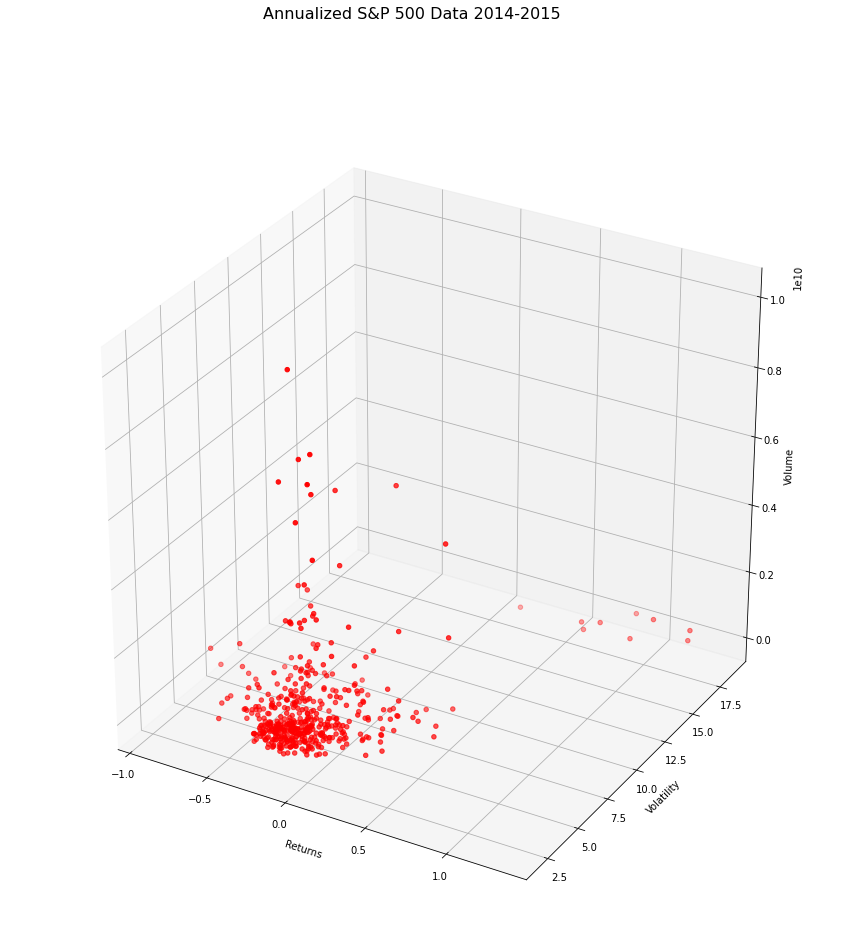

In [575]:
#regraph after outliers are dropped

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('Annualized S&P 500 Data 2014-2015', fontsize=16)

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)
z = list(ret_var_vol['Volume'].dropna().values)
#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, z, c='r', marker='o')
#ax.title("Annualized S&P500 Data")

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()

##Using PCA to Reduce Dimensionality

The dimensionality of the data chosen for the analysis below is arbitrary. The most common measures of a stock's performance in portfolio optimization analysis are mean and variance. However, since the data obtained from the AlphaVantage API includes additional dimensionality, it is worth exploring if the additional dimensions would add richness to our analysis.

Before we perform our clustering analysis, we can determine the most prominent features in the data using a Principal Component Analysis. This will be used to reduce the 5 dimensional data into a smaller amount of principal components. The clustering analysis can then be performed

First the data needs to be standardized as PCA is affected by scale. Normalizing will improve the maximization of the variance for each component that is needed in PCA.

In [576]:
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

"""
Need to determine whether or not stocks that have their values estimated by imputer
need to just be dropped from the dataframe altogether

"""
#use imputer to remobe NaN values and replace with mean along each column
imp = SimpleImputer(strategy="mean")
scale = StandardScaler()
print(annualized_data)

#use scaler to normalize data before clustering
annualized_data_scaled = scale.fit_transform(imp.fit_transform(annualized_data.values))
print(annualized_data_scaled)

        Returns Volatility       Volume HighLowDiff OpenCloseDiff
MMM   -0.192913    2.39916  5.90628e+08   0.0120139   0.000711119
ABT   -0.179184    2.56219  1.33327e+09   0.0146175   0.000502251
ABBV -0.0819894    4.43024  2.60313e+09   0.0221427   0.000568866
ABMD  -0.913676    6.76712  9.48344e+07   0.0307168    0.00185815
ACN  -0.0988941    2.73051  6.90803e+08   0.0140433   0.000706258
...         ...        ...          ...         ...           ...
YUM  -0.0580078    3.26328  7.98818e+08   0.0157174   0.000238743
ZBRA  -0.213887    4.39027  1.31668e+08   0.0230687    0.00090546
ZBH   -0.195326    3.44852  3.14272e+08   0.0162313  -6.55949e-05
ZION   0.143904    3.47235   6.4069e+08   0.0205199  -0.000154421
ZTS   -0.439027    3.25018  9.31993e+08   0.0175066    0.00123164

[503 rows x 5 columns]
[[-0.33226365 -0.34665769 -0.23759646 -1.20708077  0.50430022]
 [-0.29683287 -0.31580302  0.22794259 -0.73824553  0.18733628]
 [-0.0459961   0.03773445  1.02397418  0.61683752  0.28842

Now we can calculate the explained variance for each attribute

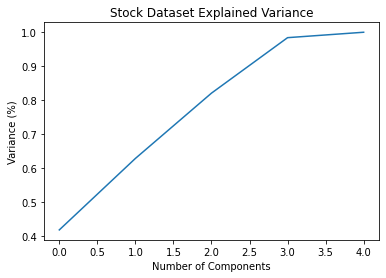

In [577]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(annualized_data_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Stock Dataset Explained Variance')
plt.show()

This indicates that there are only 3 components the indicate almost 100% of the variance in the model, therefore implying that there are only 3 principal components that need to be calculated. We can now proceed to perform the PCA analysis.

In [578]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(annualized_data_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
print(principalDf)

     principal component 1  principal component 2  principal component 3
0                -0.827167              -0.499758               0.955868
1                -0.469223              -0.518351               0.321205
2                 0.335422               0.308064              -0.765054
3                -1.661106               3.161993              -0.901419
4                -0.557123              -0.270784               0.753985
..                     ...                    ...                    ...
498              -0.150608              -0.512884               0.296578
499              -0.529764               1.172392              -0.120763
500              -0.307203              -0.642535               0.093202
501               0.479123              -0.303339              -0.346215
502              -1.160760               0.641737               0.338544

[503 rows x 3 columns]


Now we can concatenate the tickers onto the principal components dataframe

In [579]:
tickers = pd.DataFrame(annualized_data.index, columns=['Tickers'])
labeled_pca_df = pd.concat([tickers, principalDf],axis = 1).dropna()
print(labeled_pca_df)

    Tickers  ...  principal component 3
0       MMM  ...               0.955868
1       ABT  ...               0.321205
2      ABBV  ...              -0.765054
3      ABMD  ...              -0.901419
4       ACN  ...               0.753985
..      ...  ...                    ...
498     YUM  ...               0.296578
499    ZBRA  ...              -0.120763
500     ZBH  ...               0.093202
501    ZION  ...              -0.346215
502     ZTS  ...               0.338544

[503 rows x 4 columns]


In [580]:
#drop outliers
#outliers seem to have high principal component 3 value
#outlier = labeled_PCA_df['principal component 3'] == max(labeled_PCA_df['principal component 3'],key=abs)
#outlierTicker = labeled_PCA_df[outlier]['Tickers']
#outlierIndex = labeled_PCA_df[outlier].index
#print(outlierTicker)
#print(outlierIndex, "\n")

outlierTickers = ['AAPL', 'BAC', 'HBI', 'V']
print(labeled_pca_df)
outlierIndex = labeled_pca_df[labeled_pca_df['Tickers'].isin(outlierTickers)].index
labeled_pca_df.drop(outlierIndex, inplace =True)
print(labeled_pca_df)

    Tickers  ...  principal component 3
0       MMM  ...               0.955868
1       ABT  ...               0.321205
2      ABBV  ...              -0.765054
3      ABMD  ...              -0.901419
4       ACN  ...               0.753985
..      ...  ...                    ...
498     YUM  ...               0.296578
499    ZBRA  ...              -0.120763
500     ZBH  ...               0.093202
501    ZION  ...              -0.346215
502     ZTS  ...               0.338544

[503 rows x 4 columns]
    Tickers  ...  principal component 3
0       MMM  ...               0.955868
1       ABT  ...               0.321205
2      ABBV  ...              -0.765054
3      ABMD  ...              -0.901419
4       ACN  ...               0.753985
..      ...  ...                    ...
498     YUM  ...               0.296578
499    ZBRA  ...              -0.120763
500     ZBH  ...               0.093202
501    ZION  ...              -0.346215
502     ZTS  ...               0.338544

[499 rows x 4 c

Now we can plot the principal components in principal component space

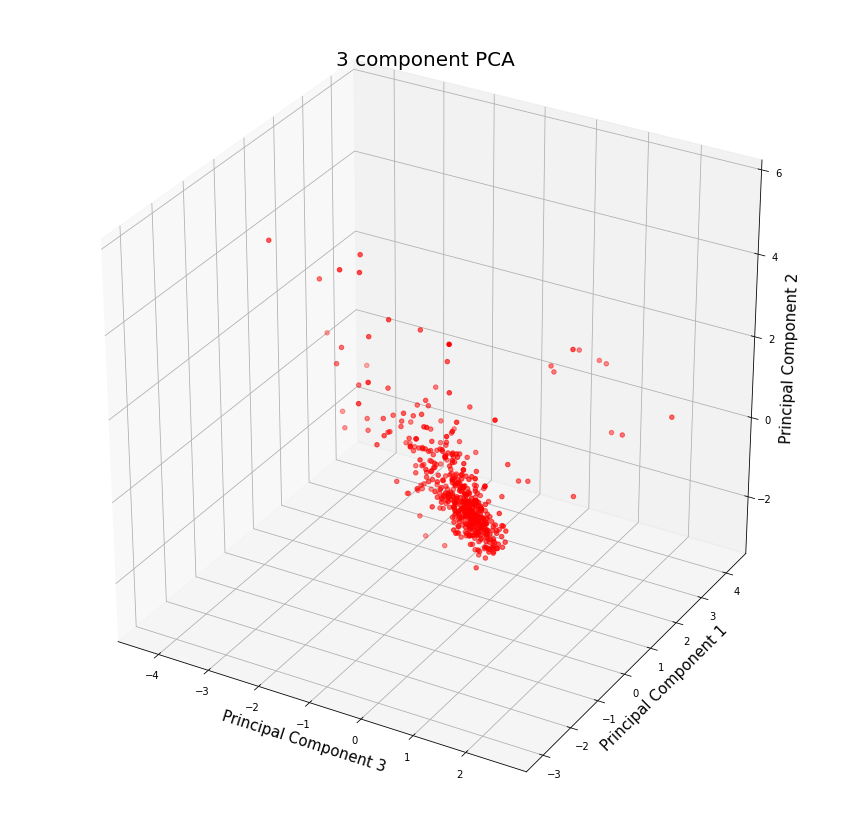

In [581]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 1', fontsize = 15)
ax.set_zlabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

x = list(labeled_pca_df['principal component 3'].dropna().values)
y = list(labeled_pca_df['principal component 1'].dropna().values)
z = list(labeled_pca_df['principal component 2'].dropna().values)

ax.scatter(x, y, z, c='r', marker='o')


plt.show()

## Clustering Analysis | PCA Data

Now that the data has been converted from a 5d to a 3d space, we can perform the clustering analysis

In [0]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [0]:
X = labeled_pca_df.drop('Tickers', axis=1).values

Text(0.5, 1.0, 'Elbow curve')

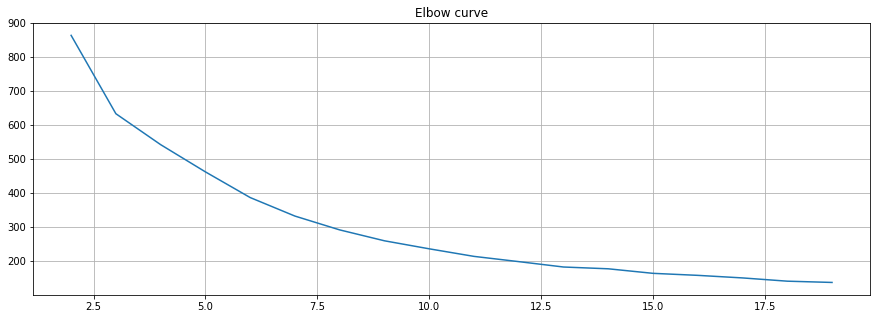

In [584]:
#generate elbow curve
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

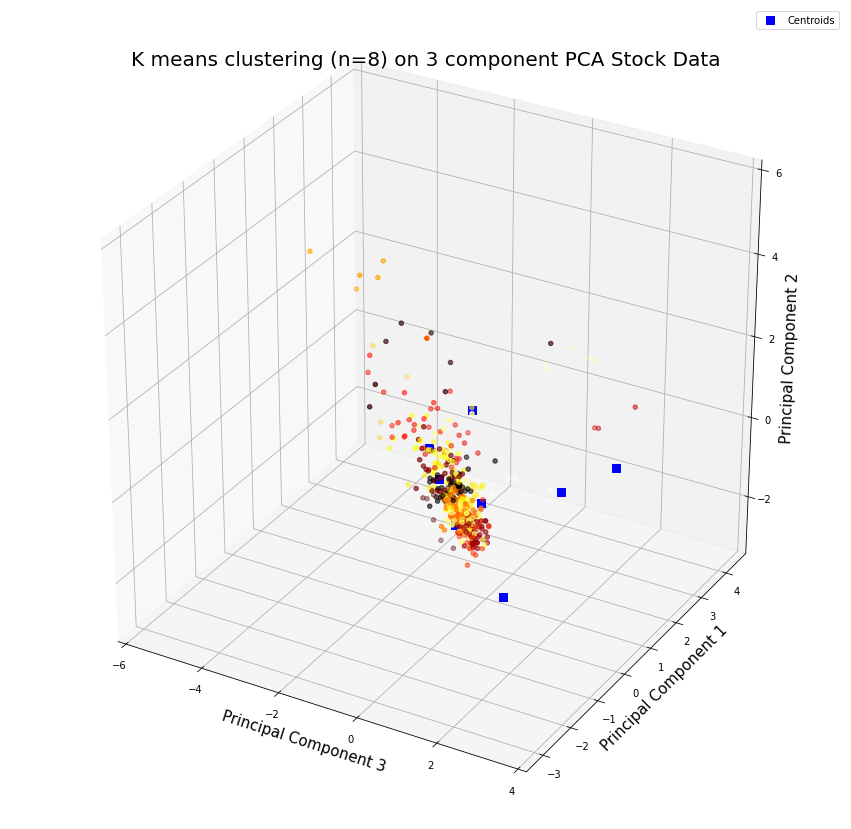

In [585]:
import  pylab as pl

#compute K means with n = 8 and get centroids
kmeans = KMeans(n_clusters = 8)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)
#print(kmeans.labels_)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 1', fontsize = 15)
ax.set_zlabel('Principal Component 2', fontsize = 15)
ax.set_title('K means clustering (n=8) on 3 component PCA Stock Data', fontsize = 20)

x = list(labeled_pca_df['principal component 3'].dropna().values)
y = list(labeled_pca_df['principal component 1'].dropna().values)
z = list(labeled_pca_df['principal component 2'].dropna().values)


ax.scatter(x, y, z, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Principal Component 3')
ax.set_ylabel('Principal Component 1')
ax.set_zlabel('Principal Component 2')
ax.set_xlim(-6,4)

plt.show()

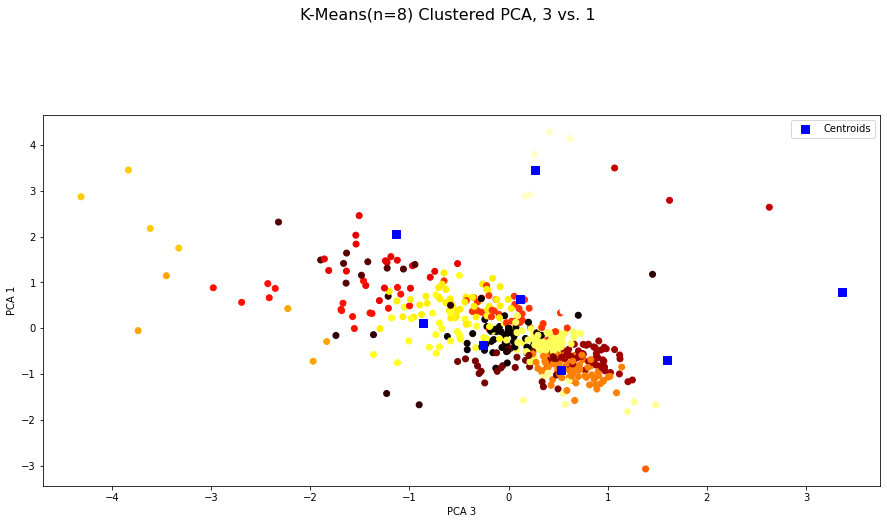

In [586]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=8) Clustered PCA, 3 vs. 1', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1], 'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('PCA 3')
ax.set_ylabel('PCA 1')

plt.show()

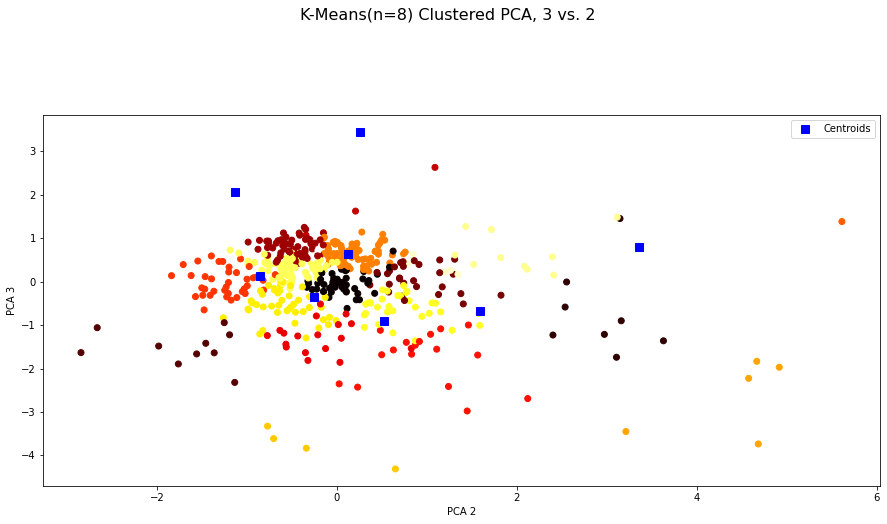

In [587]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=8) Clustered PCA, 3 vs. 2', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(z, x, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1], 'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('PCA 2')
ax.set_ylabel('PCA 3')

plt.show()

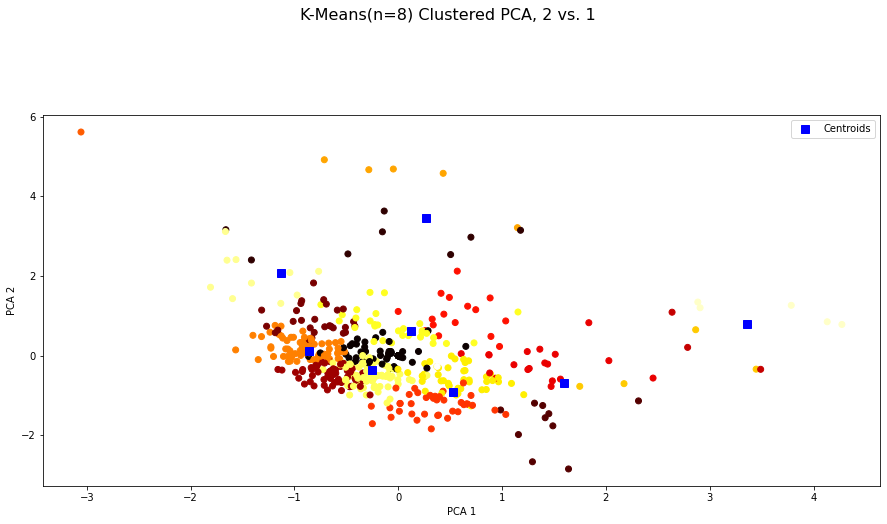

In [588]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=8) Clustered PCA, 2 vs. 1', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(y, z, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1], 'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

plt.show()

In [589]:
cluster_labels = pd.DataFrame(kmeans.labels_,columns=['Cluster'])
labeled_stocks_pca = cluster_labels.set_index(labeled_pca_df['Tickers'])
print(labeled_stocks_pca)

         Cluster
Tickers         
MMM            0
ABT            6
ABBV           5
ABMD           3
ACN            0
...          ...
YUM            6
ZBRA           5
ZBH            6
ZION           2
ZTS            0

[499 rows x 1 columns]


##Clustering Analysis | Returns, Volume, Volatility

In [0]:
#taken from: https://towardsdatascience.com/machine-learning-for-stock-clustering-using-k-means-algorithm-126bc1ace4e1
#https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt



In order to ensure accurate clustering results, we can now scale the variance and volume data

In [591]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#use imputer to remobe NaN values and replace with mean along each column
imp = SimpleImputer(strategy="mean")
scale = StandardScaler()
print(ret_var_vol)
unscaled_ret_var_vol = ret_var_vol
#use scaler to normalize data before clustering
X = scale.fit_transform(imp.fit_transform(ret_var_vol.values))
print(X)

        Returns Volatility       Volume
MMM   -0.192913    2.39916  5.90628e+08
ABT   -0.179184    2.56219  1.33327e+09
ABBV -0.0819894    4.43024  2.60313e+09
ABMD  -0.913676    6.76712  9.48344e+07
ACN  -0.0988941    2.73051  6.90803e+08
...         ...        ...          ...
YUM  -0.0580078    3.26328  7.98818e+08
ZBRA  -0.213887    4.39027  1.31668e+08
ZBH   -0.195326    3.44852  3.14272e+08
ZION   0.143904    3.47235   6.4069e+08
ZTS   -0.439027    3.25018  9.31993e+08

[499 rows x 3 columns]
[[-0.43364283 -0.70537874 -0.25429496]
 [-0.37713385 -0.62678623  0.34007239]
 [ 0.02292874  0.27373865  1.35638923]
 ...
 [-0.44357362 -0.19951925 -0.47547337]
 [ 0.95272515 -0.18802795 -0.21422866]
 [-1.44666943 -0.29512803  0.01891219]]


In [592]:
ret_var_vol = pd.DataFrame(data = X
             , columns = ['Returns', 'Volatility', 'Volume'])
print(ret_var_vol)

      Returns  Volatility    Volume
0   -0.433643   -0.705379 -0.254295
1   -0.377134   -0.626786  0.340072
2    0.022929    0.273739  1.356389
3   -3.400362    1.400268 -0.651097
4   -0.046653   -0.545646 -0.174121
..        ...         ...       ...
494  0.121639   -0.288815 -0.087673
495 -0.519971    0.254468 -0.621619
496 -0.443574   -0.199519 -0.475473
497  0.952725   -0.188028 -0.214229
498 -1.446669   -0.295128  0.018912

[499 rows x 3 columns]


Text(0.5, 1.0, 'Elbow curve')

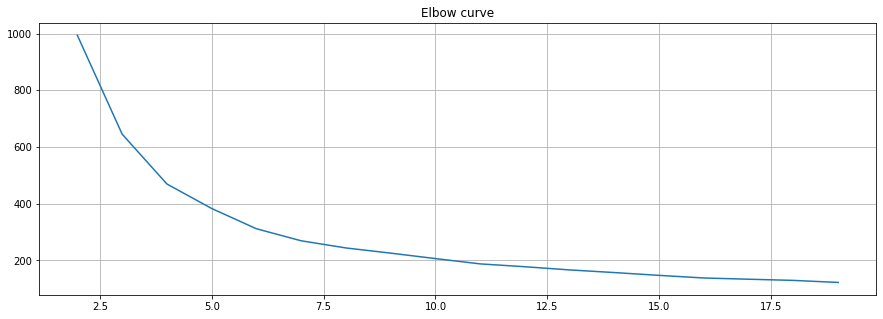

In [593]:
#generate elbow curve
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Now we can undertake in the K-means clustering and plot the results

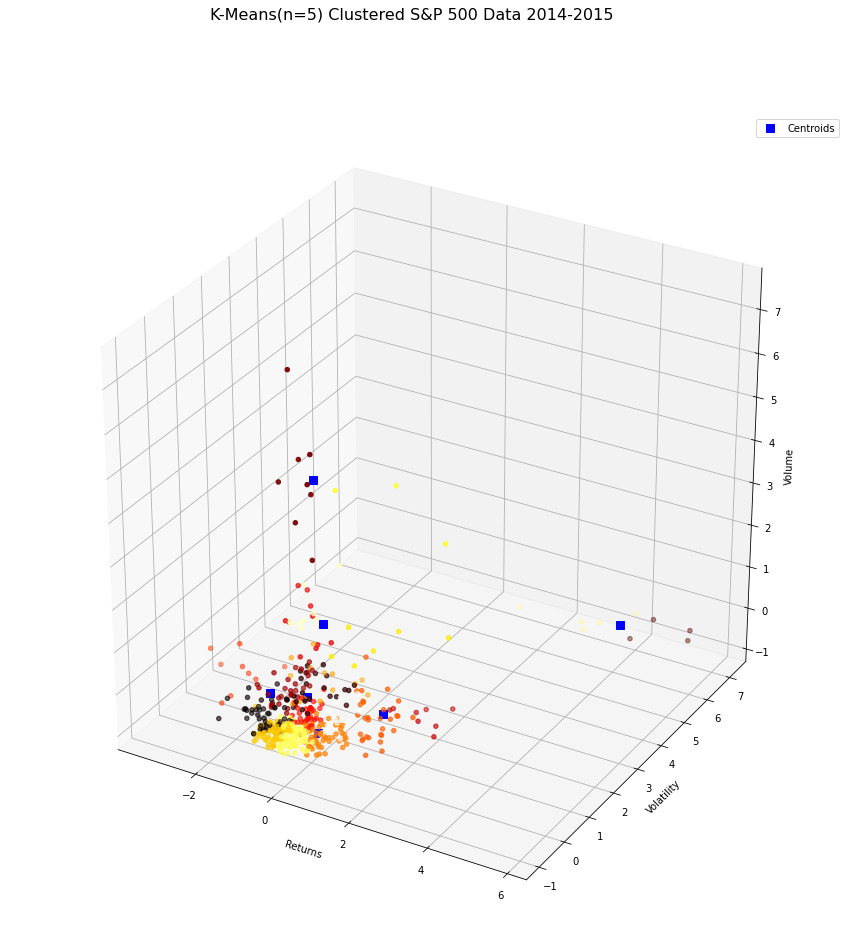

In [594]:
import  pylab as pl

#compute K means with n = 8 and get centroids
kmeans = KMeans(n_clusters = 8)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)
#print(kmeans.labels_)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)

x = list(ret_var_vol['Returns'].values)
y = list(ret_var_vol['Volatility'].values)
z = list(ret_var_vol['Volume'].values)

ax.scatter(x, y, z, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()



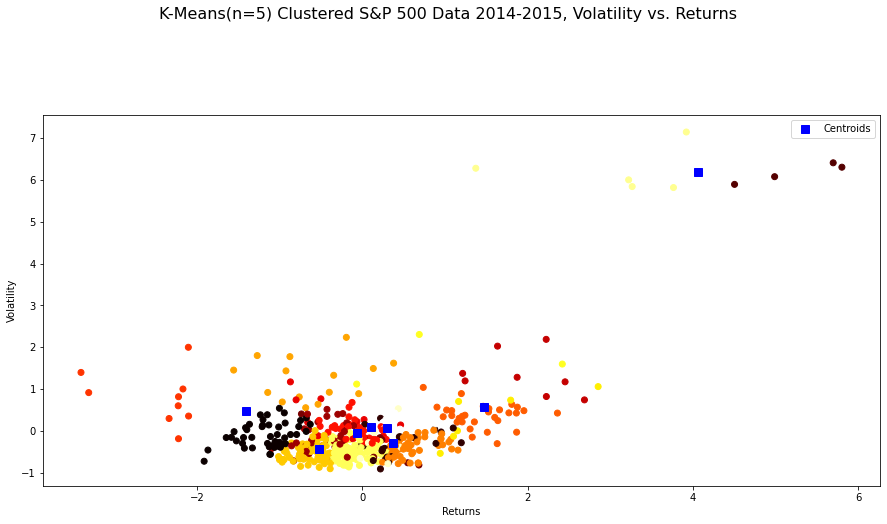

In [595]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015, Volatility vs. Returns', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1], 'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')

plt.show()

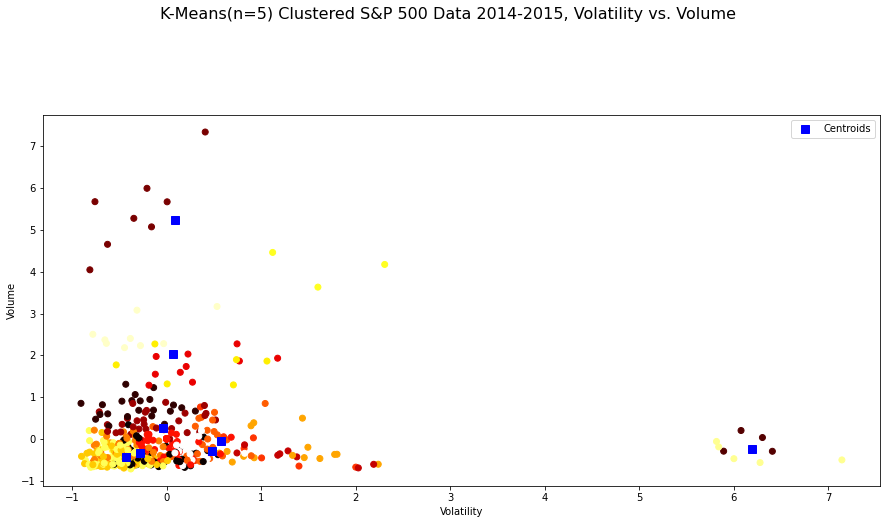

In [596]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015, Volatility vs. Volume', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(y, z, c=k_means.labels_, marker='o')
plot(centroids[:,1],centroids[:,2], 'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Volatility')
ax.set_ylabel('Volume')

plt.show()

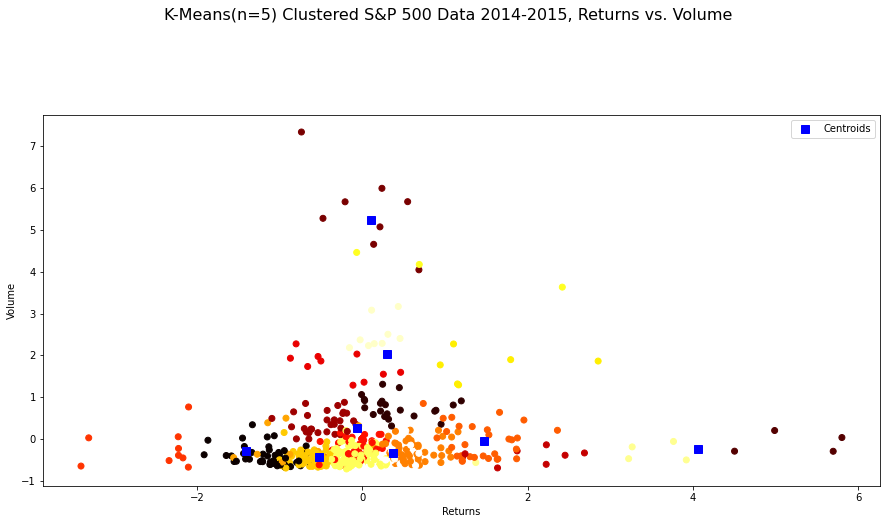

In [597]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015, Returns vs. Volume', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(x, z, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,2], 'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volume')

plt.show()

We try diffrent axes configurations to get additional perspectives of the data

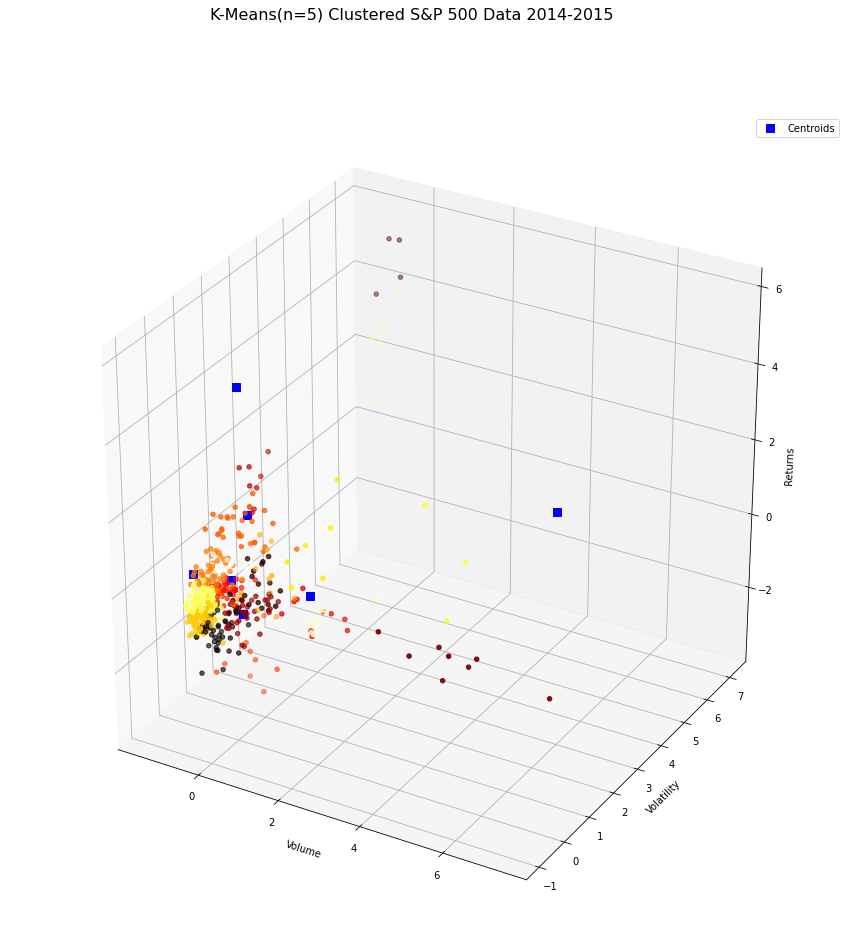

In [598]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)

ax.scatter(z, y, x, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Volume')
ax.set_ylabel('Volatility')
ax.set_zlabel('Returns')

plt.show()

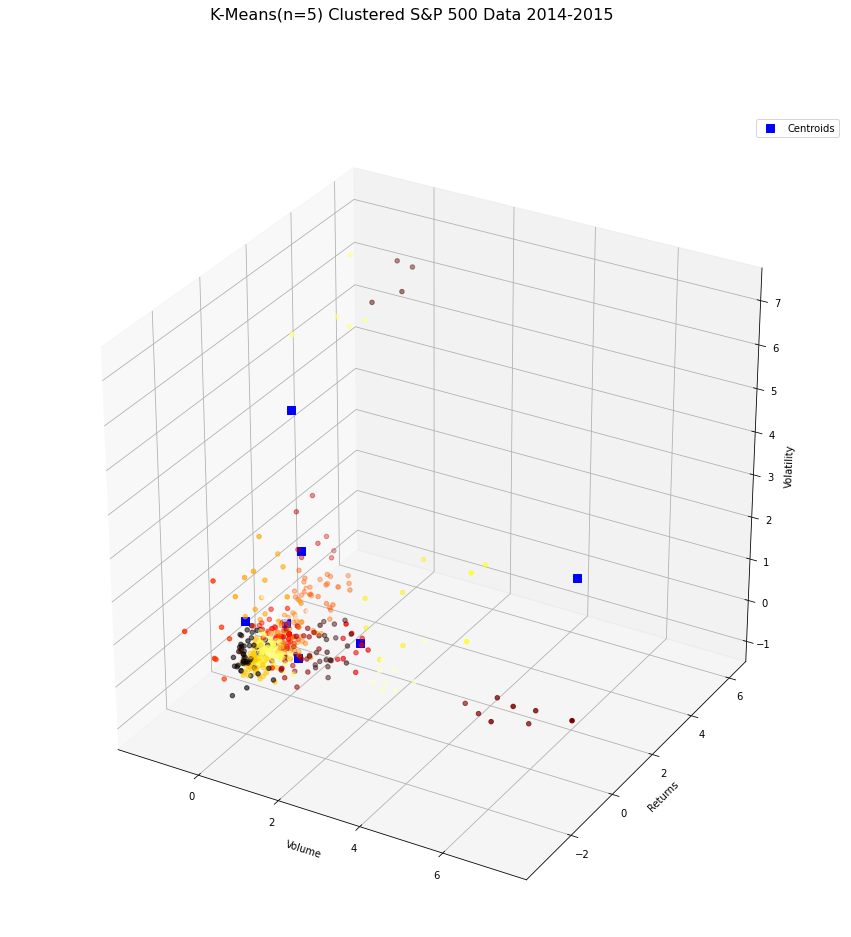

In [599]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)


ax.scatter(z, x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Volume')
ax.set_ylabel('Returns')
ax.set_zlabel('Volatility')

plt.show()

Now that the clustering has been completed, we can create a new dataframe composed on the ticker names and their cluster labels.

In [600]:
#tickers = pd.DataFrame(unscaled_ret_var_vol.index, columns=['Tickers'])
cluster_labels = pd.DataFrame(kmeans.labels_,columns=['Cluster'])
#labeled_stocks_3d = pd.concat([tickers, cluster_labels],axis = 1)
labeled_stocks_3d = cluster_labels.set_index(unscaled_ret_var_vol.index)
print(labeled_stocks_3d)

      Cluster
MMM         1
ABT         7
ABBV        4
ABMD        6
ACN         3
...       ...
YUM         3
ZBRA        1
ZBH         1
ZION        3
ZTS         6

[499 rows x 1 columns]


## Clustering Analysis | Returns, Volatility

A second clustering analysis can be done with just the returns and volatility parameters. The results of clustering on imporvement of diversification from this analysis and the three parameter analysis can be later compared.

In [601]:
#generate new dataframe with only two parameters
print(ret_var_vol)
ret_var = ret_var_vol.drop(['Volume'], axis=1)
print(ret_var)

      Returns  Volatility    Volume
0   -0.433643   -0.705379 -0.254295
1   -0.377134   -0.626786  0.340072
2    0.022929    0.273739  1.356389
3   -3.400362    1.400268 -0.651097
4   -0.046653   -0.545646 -0.174121
..        ...         ...       ...
494  0.121639   -0.288815 -0.087673
495 -0.519971    0.254468 -0.621619
496 -0.443574   -0.199519 -0.475473
497  0.952725   -0.188028 -0.214229
498 -1.446669   -0.295128  0.018912

[499 rows x 3 columns]
      Returns  Volatility
0   -0.433643   -0.705379
1   -0.377134   -0.626786
2    0.022929    0.273739
3   -3.400362    1.400268
4   -0.046653   -0.545646
..        ...         ...
494  0.121639   -0.288815
495 -0.519971    0.254468
496 -0.443574   -0.199519
497  0.952725   -0.188028
498 -1.446669   -0.295128

[499 rows x 2 columns]


####2D Plot | Returns, Volatility

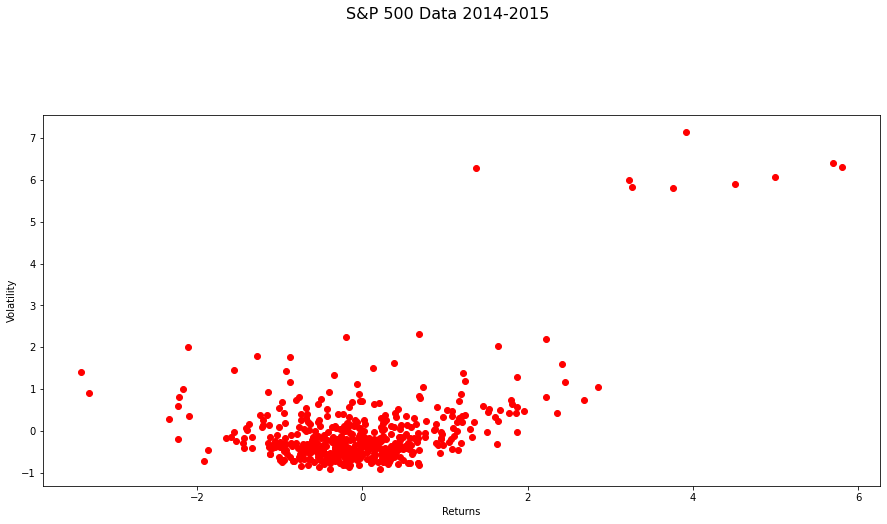

In [602]:
#first plot data 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2 ,1 ,1)
fig.suptitle('S&P 500 Data 2014-2015', fontsize=16)

x = list(ret_var['Returns'].dropna().values)
y = list(ret_var['Volatility'].dropna().values)

#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, c='r', marker='o')

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')

plt.show()

In [0]:
#taken from: https://towardsdatascience.com/machine-learning-for-stock-clustering-using-k-means-algorithm-126bc1ace4e1
#https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt



In [604]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

print(ret_var)
#use imputer to remobe NaN values and replace with mean along each column
imp = SimpleImputer(strategy="mean")
scale = StandardScaler()
#use scaler to normalize data before clustering
X = ret_var.values
print(X)

      Returns  Volatility
0   -0.433643   -0.705379
1   -0.377134   -0.626786
2    0.022929    0.273739
3   -3.400362    1.400268
4   -0.046653   -0.545646
..        ...         ...
494  0.121639   -0.288815
495 -0.519971    0.254468
496 -0.443574   -0.199519
497  0.952725   -0.188028
498 -1.446669   -0.295128

[499 rows x 2 columns]
[[-4.33642828e-01 -7.05378737e-01]
 [-3.77133852e-01 -6.26786228e-01]
 [ 2.29287422e-02  2.73738653e-01]
 [-3.40036182e+00  1.40026817e+00]
 [-4.66525211e-02 -5.45645979e-01]
 [ 3.10562914e-02  1.60150870e-01]
 [-2.79483747e-02  6.42660466e-02]
 [ 2.42055544e+00  1.60060054e+00]
 [-2.98781888e-01 -1.80803464e-01]
 [ 9.54526438e-01 -2.24297746e-02]
 [ 3.36532455e-01 -6.96158221e-01]
 [ 1.87422832e+00  1.28438045e+00]
 [-5.48617430e-01 -2.75435086e-01]
 [-3.19901817e-01  6.18523333e-02]
 [ 3.22266663e+00  6.00138227e+00]
 [ 1.52776596e+00  4.56204558e-01]
 [-9.67440553e-01 -7.43128826e-01]
 [-2.82647822e-02  7.25717702e-01]
 [ 2.80150557e-01  3.78972752e-01]

Text(0.5, 1.0, 'Elbow curve')

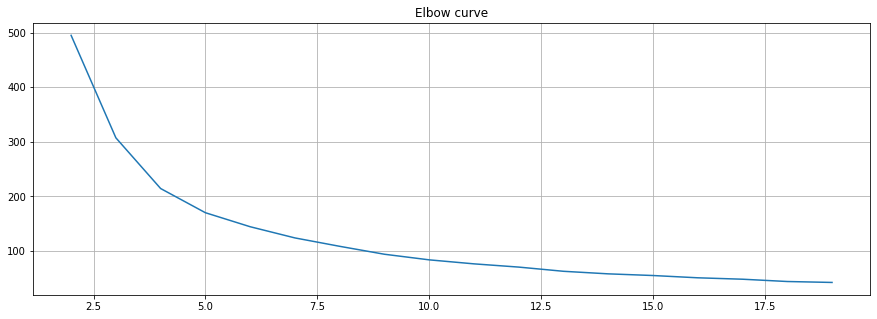

In [605]:
#generate elbow curve
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

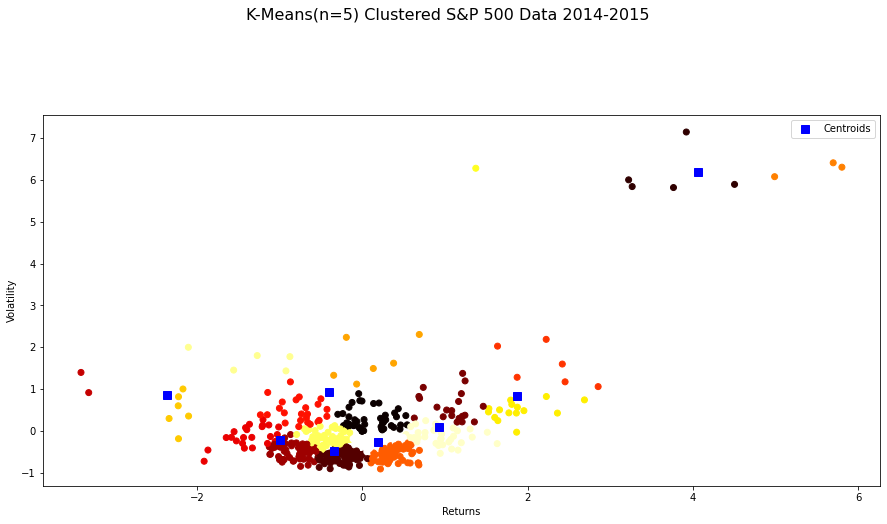

In [606]:
import  pylab as pl
from sklearn.preprocessing import StandardScaler

#compute K means with n = 5 and get centroids
kmeans = KMeans(n_clusters = 8)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)
#print(kmeans.labels_)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,1,1)
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)

ax.scatter(x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],'sb',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')

plt.show()


In [607]:
#tickers = pd.DataFrame(unscaled_ret_var_vol.index, columns=['Tickers'])
cluster_labels = pd.DataFrame(kmeans.labels_,columns=['Cluster'])
#labeled_stocks_2d = pd.concat([tickers, cluster_labels],axis = 1)
labeled_stocks_2d = cluster_labels.set_index(unscaled_ret_var_vol.index)
print(labeled_stocks_2d)

      Cluster
MMM         0
ABT         0
ABBV        6
ABMD        3
ACN         0
...       ...
YUM         6
ZBRA        7
ZBH         0
ZION        2
ZTS         7

[499 rows x 1 columns]


## Results

Now we can compare the cluster labeling between the two analyses to see if adding volume as an additional parameter had a signifigant chnage on the clustering results. We can also check the clustering of the 3d analysis vs the PCA analysis.

In [608]:
print("2D Analysis Labeled Stocks: ")
print(labeled_stocks_2d)
print()

print("3D Analysis Labeled Stocks: ")
print(labeled_stocks_3d)
print()

print("PCA Labeled Stocks: ")
print(labeled_stocks_pca)

print("Same results for 2D and 3D:")
result = labeled_stocks_2d[labeled_stocks_2d['Cluster'] == labeled_stocks_3d['Cluster']]
print(len(result))

print("Same results for 3D and PCA:")
result = labeled_stocks_3d[labeled_stocks_3d['Cluster'] == labeled_stocks_pca['Cluster']]
print(len(result))

print("Same results for 2D and PCA:")
result = labeled_stocks_2d[labeled_stocks_2d['Cluster'] == labeled_stocks_pca['Cluster']]
print(len(result))

2D Analysis Labeled Stocks: 
      Cluster
MMM         0
ABT         0
ABBV        6
ABMD        3
ACN         0
...       ...
YUM         6
ZBRA        7
ZBH         0
ZION        2
ZTS         7

[499 rows x 1 columns]

3D Analysis Labeled Stocks: 
      Cluster
MMM         1
ABT         7
ABBV        4
ABMD        6
ACN         3
...       ...
YUM         3
ZBRA        1
ZBH         1
ZION        3
ZTS         6

[499 rows x 1 columns]

PCA Labeled Stocks: 
         Cluster
Tickers         
MMM            0
ABT            6
ABBV           5
ABMD           3
ACN            0
...          ...
YUM            6
ZBRA           5
ZBH            6
ZION           2
ZTS            0

[499 rows x 1 columns]
Same results for 2D and 3D:
8
Same results for 3D and PCA:
11
Same results for 2D and PCA:
221


Now we can pick 1 stock from 6 clusters and 2 stocks from 2 clusters and plot the behavior of the stocks over the next year

In [626]:
import random
tickers = labeled_stocks_2d[labeled_stocks_2d['Cluster'] == 1]
index = tickers.sample().index[0]
print(index)

GOOGL


In [629]:
import random
#generate list of tickers from cluster numbers given dataframe

def get_clustered_tickers(df):
  tickers = []
  
  #first generate 8 ticker numbers from clusters
  for i in range(0,8):
    cluster_tickers = df[df["Cluster"] == i]
    ticker = cluster_tickers.sample().index[0]
    tickers.append(ticker) 

  #now generate 2 more
  for i in range(0,2):
    cluster_number = random.randint(0,7)
    cluster_tickers = df[df["Cluster"] == cluster_number]
    ticker = cluster_tickers.sample().index[0]
    tickers.append(ticker)

  return tickers

print(get_clustered_tickers(labeled_stocks_2d))

['NLOK', 'DISCK', 'PSX', 'AVGO', 'XLNX', 'MPC', 'AJG', 'ANTM', 'LKQ', 'WBA']


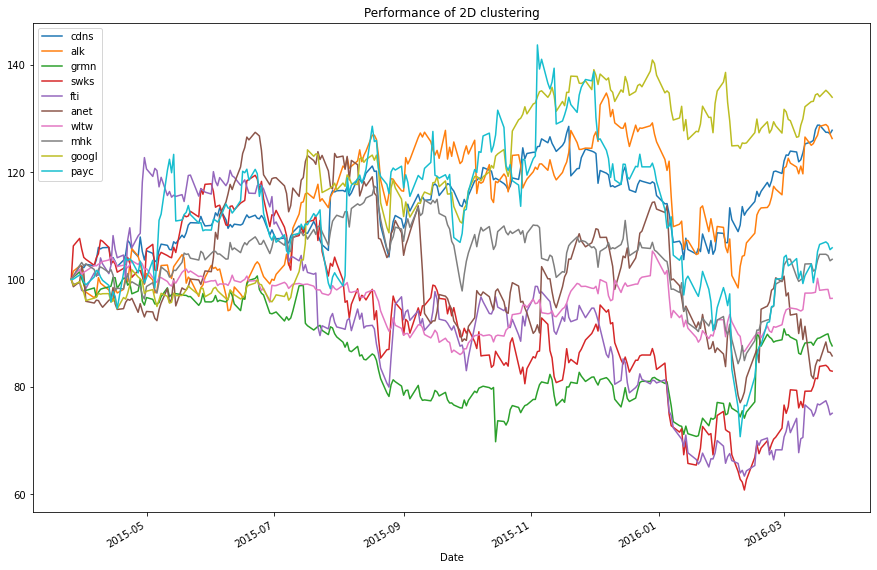

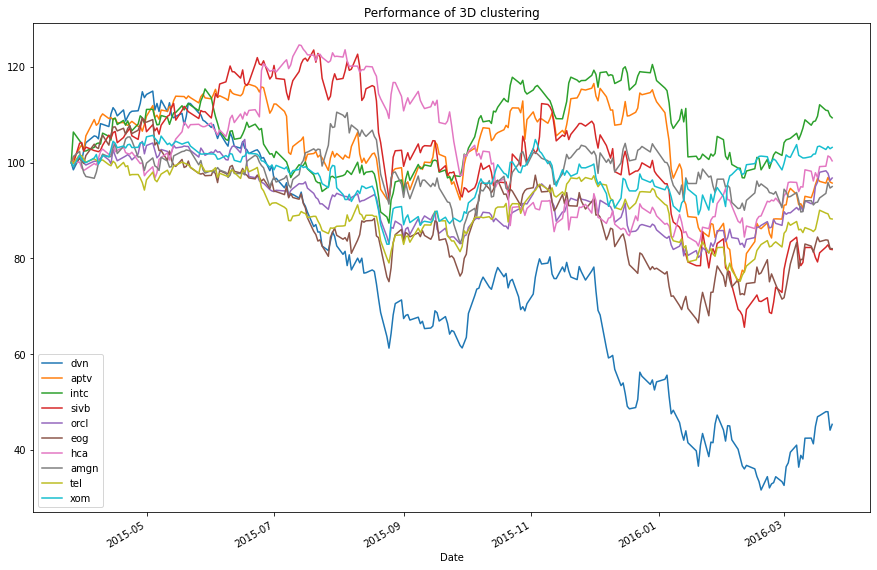

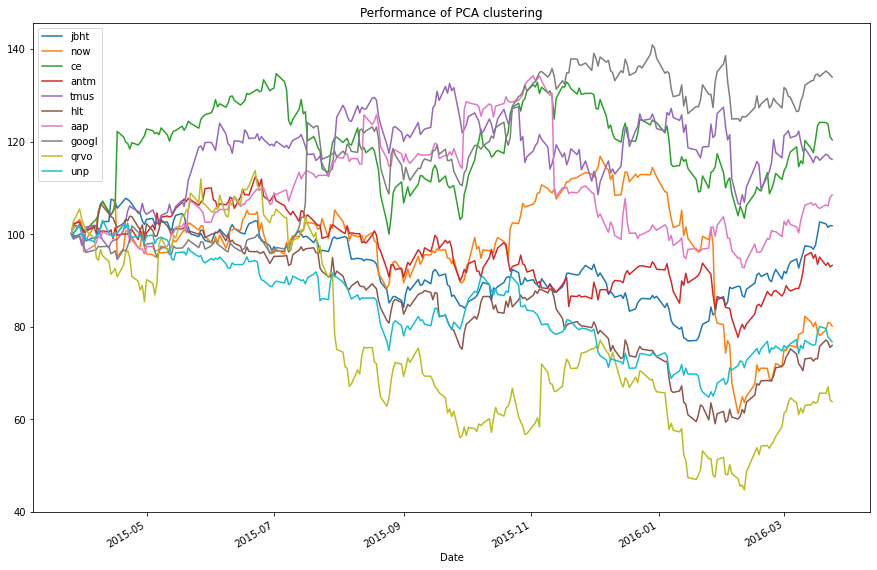

In [632]:
#plot performance of the 3 portfolios over the next year
!pip install ffn
import ffn

clustered_tickers_2d = get_clustered_tickers(labeled_stocks_2d)
clustered_tickers_3d = get_clustered_tickers(labeled_stocks_3d)
clustered_tickers_pca = get_clustered_tickers(labeled_stocks_pca)

prices = ffn.get(clustered_tickers_2d, start='2015-03-26', end='2016-03-26')
ax1 = prices.rebase().plot(title="Performance of 2D clustering", figsize=(15, 10))

prices = ffn.get(clustered_tickers_3d, start='2015-03-26', end='2016-03-26')
ax1 = prices.rebase().plot(title="Performance of 3D clustering", figsize=(15, 10))

prices = ffn.get(clustered_tickers_pca, start='2015-03-26', end='2016-03-26')
ax1 = prices.rebase().plot(title="Performance of PCA clustering", figsize=(15, 10))